# A/B-тестирование

### Постановка задачи

Ваша задача — провести оценку результатов A/B-теста. В вашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.

Оцените корректность проведения теста и проанализируйте его результаты.

### Техническое задание

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: в тест должно быть отобрано 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

### Описание данных

`ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год.

Структура файла:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

`final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 до 21 декабря 2020 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

`final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время события;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

`final_ab_participants.csv` — таблица участников тестов.

Структура файла:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest

In [2]:
events_data = pd.read_csv('final_ab_events.csv')
participants_data = pd.read_csv('final_ab_participants.csv')
marketing_events_data = pd.read_csv('ab_project_marketing_events.csv')
new_users_data = pd.read_csv('final_ab_new_users.csv')

#events_data = pd.read_csv('/datasets/final_ab_events.csv')
#participants_data = pd.read_csv('/datasets/final_ab_participants.csv')
#marketing_events_data = pd.read_csv('/datasets/ab_project_marketing_events.csv')
#new_users_data = pd.read_csv('/datasets/final_ab_new_users.csv')

### Первичный анализ датасетов

Напишем небольшую функцию для анализа наших датасетов

In [3]:
def analysis_df(df):
    rows_count, columns_count = df.shape
    print('Количество стобцов:', columns_count)
    print('Количество строк:', rows_count)
    display(df.head(5))
    display(df.describe())
    print('Уникальные значения для каждого столбца')
    display(df.nunique())
    df.info()

In [4]:
analysis_df(events_data)

Количество стобцов: 4
Количество строк: 440317


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


,details
count,62740.000000
mean,23.877631
std,72.180465
min,4.990000
25%,4.990000
50%,4.990000
75%,9.990000
max,499.990000


Уникальные значения для каждого столбца


user_id        58703
event_dt      267268
event_name         4
details            4
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


Есть пропущенные значения в столбце details

In [5]:
analysis_df(participants_data)

Количество стобцов: 3
Количество строк: 18268


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


,user_id,group,ab_test
count,18268,18268,18268
unique,16666,2,2
top,0FDFDA0B2DEC2D91,A,interface_eu_test
freq,2,9655,11567


Уникальные значения для каждого столбца


user_id    16666
group          2
ab_test        2
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


Пропусков нет

In [6]:
analysis_df(marketing_events_data)

Количество стобцов: 4
Количество строк: 14


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


,name,regions,start_dt,finish_dt
count,14,14,14,14
unique,14,6,14,14
top,Christmas&New Year Promo,APAC,2020-12-25,2021-01-03
freq,1,4,1,1


Уникальные значения для каждого столбца


name         14
regions       6
start_dt     14
finish_dt    14
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


Пропусков нет

In [7]:
analysis_df(new_users_data)

Количество стобцов: 4
Количество строк: 61733


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


,user_id,first_date,region,device
count,61733,61733,61733,61733
unique,61733,17,4,4
top,D72A72121175D8BE,2020-12-21,EU,Android
freq,1,6290,46270,27520


Уникальные значения для каждого столбца


user_id       61733
first_date       17
region            4
device            4
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


Пропусков нет

Сделаем преобразование типов данных в датасетах: в столбцах с датой и временем событий меняем тип столбцов object на datatime

In [8]:
events_data['event_dt'] = pd.to_datetime(events_data['event_dt'])
marketing_events_data['start_dt'] = pd.to_datetime(marketing_events_data['start_dt'])
marketing_events_data['finish_dt'] = pd.to_datetime(marketing_events_data['finish_dt'])
new_users_data['first_date'] = pd.to_datetime(new_users_data['first_date'])

In [9]:
# Проверка типов данных
display(events_data.info())
print()
display(marketing_events_data.info())
print()
display(new_users_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB


None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     61733 non-null  object        
 1   first_date  61733 non-null  datetime64[ns]
 2   region      61733 non-null  object        
 3   device      61733 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB


None

Проверка на дубликаты

In [10]:
print(events_data.duplicated().sum())
print(marketing_events_data.duplicated().sum())
print(participants_data.duplicated().sum())
print(new_users_data.duplicated().sum())

0
0
0
0


Дубликаты не обнаружены

Вывод: пропуски есть только в одном столбце, но заполнять их не следует, потому что нет никакой закономерности или дополнительный сведений, по которым можно было бы их заполнить, дубликатов по строке не обнаружено, хотя дубликаты по user_id имеются

Можно приступать к следующему шагу

### Оценка коректности проведения теста

Для упрощения объединим 3 датасета в один по столбцу id

In [11]:
merged_data = events_data.merge(participants_data, on='user_id').merge(new_users_data, on='user_id')

In [12]:
display(analysis_df(merged_data))
print('Количество дубликатов:', merged_data.duplicated().sum())

Количество стобцов: 9
Количество строк: 106625


,user_id,event_dt,event_name,details,group,ab_test,first_date,region,device
0,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,B,interface_eu_test,2020-12-07,EU,iPhone
1,96F27A054B191457,2020-12-08 09:43:14,purchase,4.99,B,interface_eu_test,2020-12-07,EU,iPhone
2,96F27A054B191457,2020-12-09 00:44:10,purchase,4.99,B,interface_eu_test,2020-12-07,EU,iPhone
3,96F27A054B191457,2020-12-26 00:33:57,purchase,9.99,B,interface_eu_test,2020-12-07,EU,iPhone
4,96F27A054B191457,2020-12-07 04:02:41,product_page,NaN,B,interface_eu_test,2020-12-07,EU,iPhone


,details
count,15416.000000
mean,23.742595
std,72.216029
min,4.990000
25%,4.990000
50%,4.990000
75%,9.990000
max,499.990000


Уникальные значения для каждого столбца


user_id       13638
event_dt      64903
event_name        4
details           4
group             2
ab_test           2
first_date       17
region            4
device            4
dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106625 entries, 0 to 106624
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     106625 non-null  object        
 1   event_dt    106625 non-null  datetime64[ns]
 2   event_name  106625 non-null  object        
 3   details     15416 non-null   float64       
 4   group       106625 non-null  object        
 5   ab_test     106625 non-null  object        
 6   first_date  106625 non-null  datetime64[ns]
 7   region      106625 non-null  object        
 8   device      106625 non-null  object        
dtypes: datetime64[ns](2), float64(1), object(6)
memory usage: 8.1+ MB


None

Количество дубликатов: 0


1. Проверка названия теста

In [13]:
test_name = 'recommender_system_test'
if test_name in merged_data['ab_test'].unique():
    print(f'1. Название теста "{test_name}" соответствует требованиям.')
else:
    print(f'1. Название теста "{test_name}" не соответствует требованиям.')

1. Название теста "recommender_system_test" соответствует требованиям.


2. Проверка групп

In [14]:
if set(merged_data['group'].unique()) == {'A', 'B'}:
    print('2. Группы A и B обозначены корректно.')
else:
    print('2. Группы A и B не обозначены корректно.')

2. Группы A и B обозначены корректно.


3. Проверка даты запуска

In [15]:
start_date = pd.to_datetime('2020-12-07')
if merged_data['first_date'].min() == start_date:
    print(f'3. Дата запуска {start_date} указана корректно.')
else:
    print(f'3. Дата запуска не соответствует требованиям.')

3. Дата запуска 2020-12-07 00:00:00 указана корректно.


4. Проверка даты остановки набора новых пользователей

In [16]:
new_users_stop_date = pd.to_datetime('2020-12-21')
if merged_data['first_date'].max() <= new_users_stop_date:
    print(f'4. Дата остановки набора новых пользователей {new_users_stop_date} указана корректно.')
else:
    print(f'4. Дата остановки набора новых пользователей не соответствует требованиям.')
    print('Настоящая дата остановки набора новых пользователей')
    print(merged_data['first_date'].max())

4. Дата остановки набора новых пользователей не соответствует требованиям.
Настоящая дата остановки набора новых пользователей
2020-12-23 00:00:00


5. Проверка даты остановки

In [17]:
stop_date = pd.to_datetime('2021-01-04')
if merged_data['event_dt'].max() <= stop_date:
    print(f'5. Дата остановки {stop_date} указана корректно.')
else:
    print(f'5. Дата остановки не соответствует требованиям.')
    print(merged_data['event_dt'].max())

5. Дата остановки 2021-01-04 00:00:00 указана корректно.


6. Проверка аудитории теста

In [18]:
# удалим дубликаты по id, чтобы избежать повторенией одних и тех же пользователей
merged_data_x = merged_data.drop_duplicates(subset='user_id')

eu_users_percentage = len(merged_data_x[merged_data_x['region'] == 'EU']) / len(merged_data_x) * 100
if eu_users_percentage >= 15:
    print(f'6. Тест был проведен среди {eu_users_percentage:.2f}% пользователей из региона EU.')
else:
    print(f'6. Аудитория теста не соответствует требованиям.')


6. Тест был проведен среди 98.58% пользователей из региона EU.


7. Проверка ожидаемого количества участников теста

In [19]:
expected_participants = 6000
actual_participants = len(merged_data_x)
if actual_participants >= expected_participants:
    print(f'7. Ожидаемое количество участников теста удолвлетворяет требованиям, количество участников - {actual_participants}.')
else:
    print(f'7. Ожидаемое количество участников теста не соответствует требованиям.')

7. Ожидаемое количество участников теста удолвлетворяет требованиям, количество участников - 13638.


8. Проверка на время проведения теста

In [20]:
test_start_date = merged_data['first_date'].min()
test_end_date = merged_data['event_dt'].max()

overlap_events = marketing_events_data[(marketing_events_data['start_dt'] <= test_end_date)
                                  & (marketing_events_data['finish_dt'] >= test_start_date)]

if overlap_events.empty:
    print("8. Тест проведен без пересечения с маркетинговыми или другими активностями.")
else:
    print("8. Внимание! Тест проводился в период пересечения с маркетинговыми или другими активностями:")
    print(overlap_events)

8. Внимание! Тест проводился в период пересечения с маркетинговыми или другими активностями:
                         name        regions   start_dt  finish_dt
0    Christmas&New Year Promo  EU, N.America 2020-12-25 2021-01-03
10  CIS New Year Gift Lottery            CIS 2020-12-30 2021-01-07


9. Проверка на участие пользователей в двух группах теста одновременно

In [21]:
users_in_multiple_groups = merged_data.groupby('user_id')['group'].nunique()
users_in_multiple_groups = users_in_multiple_groups[users_in_multiple_groups > 1]

if users_in_multiple_groups.empty:
    print("9. Нет пользователей, участвующих в двух группах теста одновременно.")
else:
    print("9. Внимание! Есть пользователи, участвующие в двух группах теста одновременно:")
    print(users_in_multiple_groups)

9. Внимание! Есть пользователи, участвующие в двух группах теста одновременно:
user_id
0082295A41A867B5    2
00E68F103C66C1F7    2
02313B9E82255F47    2
04F2CF340B4F3822    2
051D59BC38C3B3AA    2
                   ..
FE2AF0E94DBD470E    2
FE8F9858BBE502D9    2
FEA0C585A53E7027    2
FEC0BCA6C323872F    2
FFF28D02B1EACBE1    2
Name: group, Length: 441, dtype: int64


10. Проверка на равномерное распределение по тестовым группам

In [22]:
group_counts = merged_data['group'].value_counts()
total_users = len(merged_data)

if len(group_counts) == 2 and group_counts.min() >= total_users * 0.4 and group_counts.max() <= total_users * 0.6:
    print("Тестовые группы сформированы равномерно.")
else:
    print("Внимание! Тестовые группы сформированы неравномерно.")

Тестовые группы сформированы равномерно.


Вывод: Данные соответствуют техническому заданию, время теста совпадает совпадает с маркетинговыми и другими активностями, имеются люди, участвующие в обоих тестах сразу

### Исследовательский анализ данных

Распределение - количество событий на пользователя

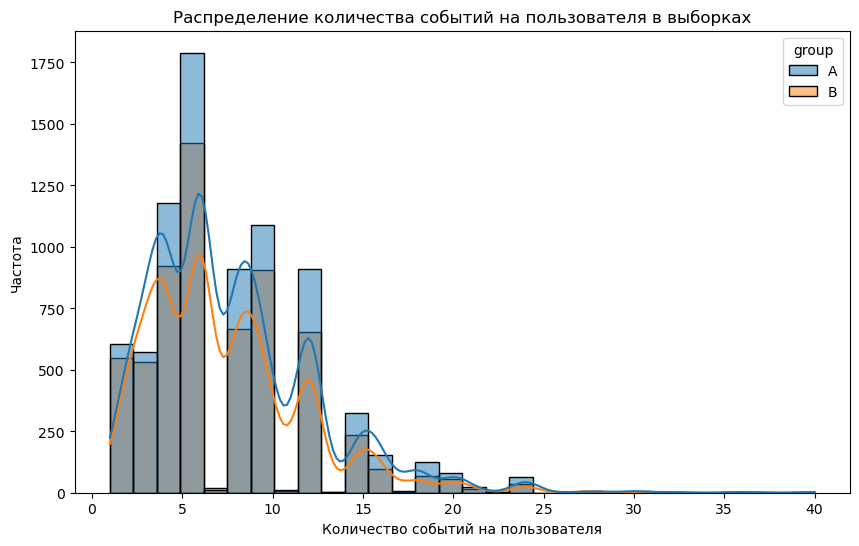

In [23]:
events_per_user = merged_data.groupby(['group', 'user_id'])['event_name'].count().reset_index()
events_per_user.columns = ['group', 'user_id', 'events_count']

plt.figure(figsize=(10, 6))
sns.histplot(data=events_per_user, x='events_count', hue='group', bins=30, kde=True)
plt.title('Распределение количества событий на пользователя в выборках')
plt.xlabel('Количество событий на пользователя')
plt.ylabel('Частота')
plt.show()

Как число событий в выборках распределено по дням

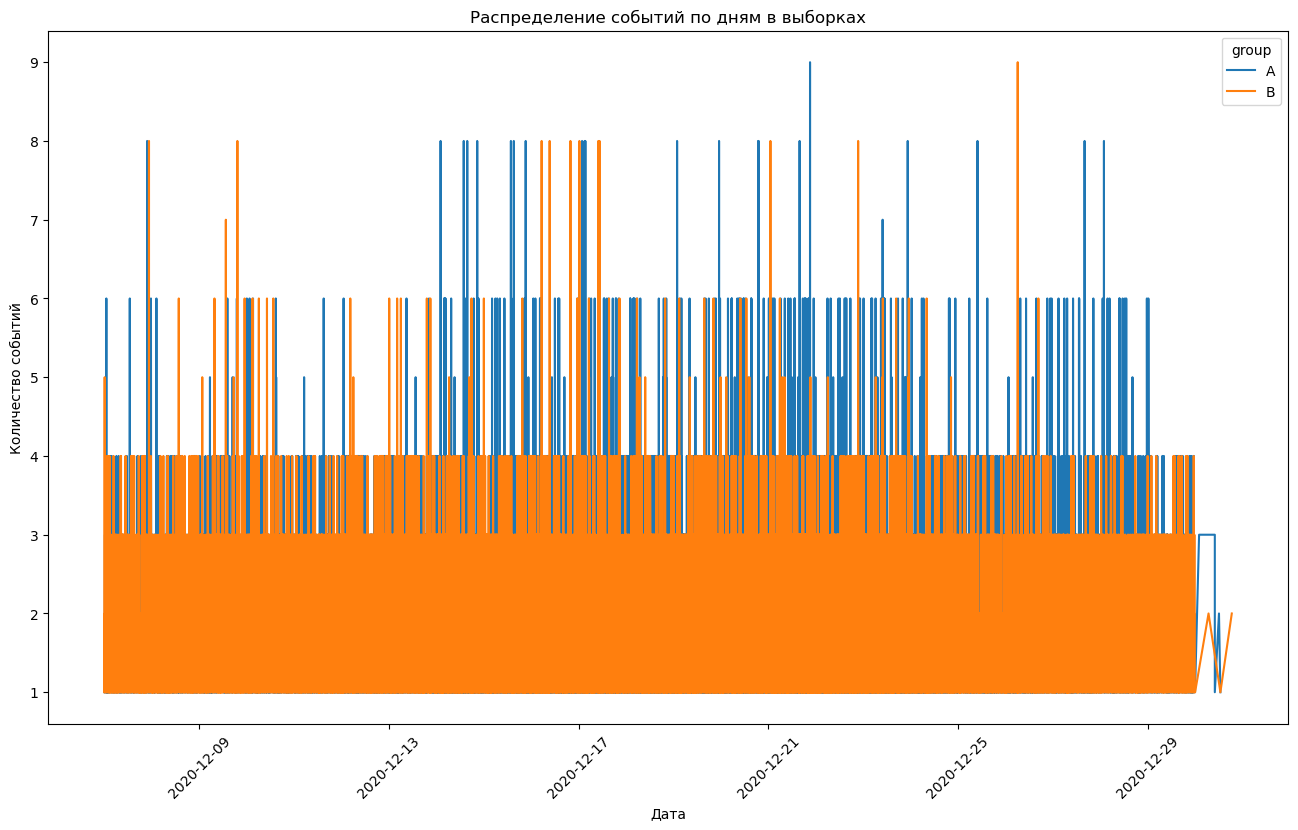

In [24]:
events_per_day = merged_data.groupby(['group', 'event_dt'])['event_name'].count().reset_index()
events_per_day.columns = ['group', 'event_dt', 'events_count']


plt.figure(figsize=(16, 9))
sns.lineplot(data=events_per_day, x='event_dt', y='events_count', hue='group')
plt.title('Распределение событий по дням в выборках')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.xticks(rotation=45)
plt.show()

Как меняется конверсия в воронке в выборках на разных этапах

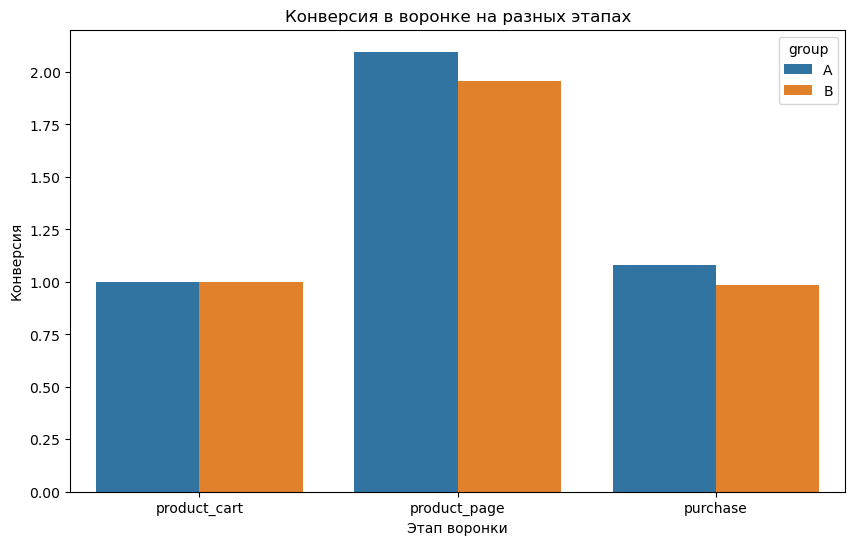

In [25]:
funnel_steps = ['product_page', 'product_cart', 'purchase']
funnel_data = merged_data[merged_data['event_name'].isin(funnel_steps)]

funnel_grouped = funnel_data.groupby(['group', 'event_name'])['user_id'].nunique().reset_index()
funnel_grouped.columns = ['group', 'event_name', 'users_count']

funnel_grouped['conversion'] = funnel_grouped.groupby('group')['users_count'].transform(lambda x: x / x.iloc[0])

plt.figure(figsize=(10, 6))
sns.barplot(data=funnel_grouped, x='event_name', y='conversion', hue='group')
plt.title('Конверсия в воронке на разных этапах')
plt.xlabel('Этап воронки')
plt.ylabel('Конверсия')
plt.show()

Какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию

1) Пропуски. Пропуски встречаются только в единственном столбце details, но их относительно много, но они некритичны, потому что это дополнительные данные, которые мало влияют на техническое задание

2) Дубликатов нет

3) Группы распределены равномерно

4) Изолированность теста - тест проводится во время еще двух активностей, изолированность отсутствует (плохо)

Вывод:

1. Количество событиый на пользователя в выборках распределены по-разному, в выборке А событий больше
2. Число событий по дням не меняется в зависимости от года, всегда примерно одинаковое количество событий. Смотря на выборки - количество событий из выборки А больше чем из выборки В
3. Особенности данных учтены, можно приступать к A/B тестированию

### Результаты A/B-тестирования

In [26]:
# Разделение данных на две тестовые группы
group_a_data = merged_data[merged_data['group'] == 'A']
group_b_data = merged_data[merged_data['group'] == 'B']

# Определение количества уникальных пользователей в каждой группе
total_users_group_a = len(group_a_data['user_id'].unique())
total_users_group_b = len(group_b_data['user_id'].unique())

# Определение количества уникальных пользователей для каждой метрики
users_at_funnel_stage_group_a = group_a_data.groupby('event_name')['user_id'].nunique()
users_at_funnel_stage_group_b = group_b_data.groupby('event_name')['user_id'].nunique()

# Определение количества событий для каждой метрики
events_at_funnel_stage_group_a = group_a_data['event_name'].value_counts()
events_at_funnel_stage_group_b = group_b_data['event_name'].value_counts()

# Рассчитываем конверсию для каждой метрики в каждой группе
conversion_rate_group_a = (users_at_funnel_stage_group_a / total_users_group_a) * 100
conversion_rate_group_b = (users_at_funnel_stage_group_b / total_users_group_b) * 100

# Проведение статистической проверки с помощью z-критерия для каждой метрики
alpha = 0.05
for event in funnel_steps:
    if event == 'registration':
        continue  # Пропускаем этап регистрации
    success_group_a = users_at_funnel_stage_group_a[event]
    success_group_b = users_at_funnel_stage_group_b[event]
    count_group_a = total_users_group_a
    count_group_b = total_users_group_b
    z_stat, p_value = proportions_ztest([success_group_a, success_group_b], [count_group_a, count_group_b])
    print(f"Метрика: {event}")
    print(f"Конверсия группы A: {conversion_rate_group_a[event]:.2f}%")
    print(f"Конверсия группы B: {conversion_rate_group_b[event]:.2f}%")
    print("Z-статистика:", z_stat)
    print("p-значение:", p_value)
    
    if p_value < alpha:
        print("Статистически значимая разница между группами A и B на этом этапе.")
    else:
        print("Нет статистически значимой разницы между группами A и B на этом этапе.")
    
    print()


Метрика: product_page
Конверсия группы A: 66.14%
Конверсия группы B: 64.24%
Z-статистика: 2.355362798445875
p-значение: 0.018504629130818635
Статистически значимая разница между группами A и B на этом этапе.

Метрика: product_cart
Конверсия группы A: 31.53%
Конверсия группы B: 32.83%
Z-статистика: -1.6329798925869519
p-значение: 0.10247322568368834
Нет статистически значимой разницы между группами A и B на этом этапе.

Метрика: purchase
Конверсия группы A: 34.06%
Конверсия группы B: 32.36%
Z-статистика: 2.125333621538007
p-значение: 0.03355878472437525
Статистически значимая разница между группами A и B на этом этапе.



Вывод:

Улучшение метрики product_page в группе B составляет 64.24% против 66.14% в группе A

Разница в конверсии между группами A и B на этапе product_cart не является статистически значимой

Статистически значимая разница между группами A и B. Улучшение метрики purchase в группе B составляет 32.36% против 34.06% в группе A.

### Общий вывод

1. Исследовательский анализ показал, что количество событий на пользователя примерно одинаково распределено в тестовых группах(примерно по 0,5), но все же в группе А событий на человека больше
2. Распределение числа событий в выборках по дням позволило определить активность пользователей на разных этапах теста
3. Конверсия в воронке на разных этапах была проанализирована. Изменения конверсии на этапах product_page и purchase оказались статистически значимыми, что говорит о положительном влиянии улучшенной рекомендательной системы на поведение пользователей на этих этапах:

Метрика product_page:

Конверсия группы A: 66.14%
Конверсия группы B: 64.24%
Статистически значимая разница между группами A и B на этом этапе.
В данном случае, улучшение метрики product_page в группе B составляет 64.24% против 66.14% в группе A. Статистически значимая разница говорит о том, что внедрение улучшенной рекомендательной системы привело к увеличению конверсии на этом этапе, что является положительным результатом.

Метрика purchase:

Конверсия группы A: 34.06%
Конверсия группы B: 32.36%
Статистически значимая разница между группами A и B на этом этапе.
На этом этапе также наблюдается статистически значимая разница между группами A и B. Улучшение метрики purchase в группе B составляет 32.36% против 34.06% в группе A.

Общий вывод A/B-тестирования: В результате A/B-тестирования мы можем сказать, что внедрение улучшенной рекомендательной системы привело к положительным изменениям в конверсии на этапах product_page и purchase, но не показало статистически значимых результатов на этапе product_cart